# Fitting data with `astropy.modeling`

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.modeling import models, fitting

from astroquery.vizier import Vizier

# Automatically displays plots in notebook
%matplotlib inline  

## Load some data with `astroquery`

We are interested in using cepheid variable data from [Bhardwaj et al. 2017](https://www.aanda.org/articles/aa/pdf/2017/09/aa30841-17.pdf)...
We can pull the data from [Vizier](http://astroquery.readthedocs.io/en/latest/vizier/vizier.html#) using [astroquery](http://astroquery.readthedocs.io/en/latest/index.html)...


In [5]:
# Search for the data
catalog_list = Vizier.find_catalogs('bhardwaj cepheid')

# To see what catalogs by Bhwardwaj are available on Vizier
# and their descriptions
print({k:v.description for k,v in catalog_list.items()})

{'J/A+A/605/A100': 'VVV survey Galactic Bulge Pop. II Cepheids (Bhardwaj+, 2017)', 'J/MNRAS/447/3342': 'Galactic and LMC Cepheids Fourier parameters (Bhardwaj+, 2015)'}


In [6]:
# We want the most recent catalog from J/A+A/605/A100
catalog_test = Vizier.get_catalogs('J/A+A/605/A100') 

print(catalog_test)


TableList with 1 tables:
	'0:J/A+A/605/A100/table1' with 16 column(s) and 50 row(s) 


In [7]:
# it only has 50 rows, but the actual data set contains 200+ cepheids
# we can change this by setting ROW_LIMIT
Vizier.ROW_LIMIT = -1

catalog = Vizier.get_catalogs('J/A+A/605/A100')
print(catalog)

TableList with 1 tables:
	'0:J/A+A/605/A100/table1' with 16 column(s) and 264 row(s) 


This print tells us that there is 1 table (index = 0) with 16 columns and 24 rows.

In [12]:
# let's see the available columns/keys in the dict
print(catalog[0].keys())

['VVV-ID', 'OGLE-ID', 'Period', 'Class', '__Vmag_', '__Imag_', '__Jmag_', '__Hmag_', '__Ksmag_', 'e__Jmag_', 'e__Hmag_', 'e__Ksmag_', 'E_J-Ks_', 'Simbad', '_RA', '_DE']


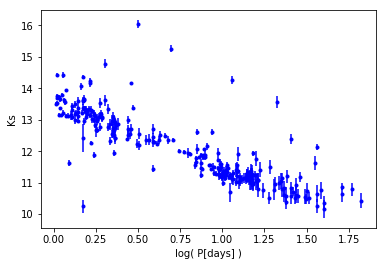

In [52]:
# We want the Period and K-band magnitudes ('__Ksmag_')
period = np.array(catalog[0]['Period']) # recast table.column to np.array
k_mag = np.array(catalog[0]['__Ksmag_'])
k_mag_err = np.array(catalog[0]['e__Ksmag_'])

log10_period = np.log10(period) # the Period-Luminosity relation is actually 
                                # a log-log relation

# visualize the data
plt.errorbar(log10_period,k_mag,yerr=k_mag_err,fmt='b.')
plt.xlabel('log( P[days] )')
plt.ylabel(r'Ks')

Remember the y-axis is in magnitudes, so the usual way to plot the data would be to have magnitudes ***decrease*** instead of increase.  Here is how we flip the y-axis.

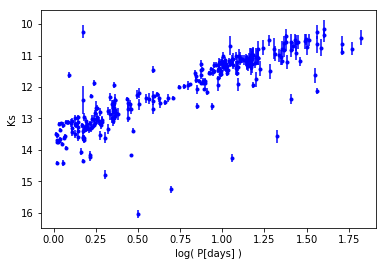

In [53]:
plt.errorbar(log10_period,k_mag,yerr=k_mag_err,fmt='b.')
plt.xlabel('log( P[days] )')
plt.ylabel(r'Ks')
plt.gca().invert_yaxis() # command to flip the y-axis

Try using different values for `fmt=` to change the marker.

Try changing the [marker](http://matplotlib.org/devdocs/api/_as_gen/matplotlib.axes.Axes.errorbar.html) to a different symbol.

## Write your own line function

Let's write a function that returns a line with slope $m$ and y-intercept $b$, so that $y = mx + b$

In [54]:
def my_line(x, m, b):
    """
    x : input data for the line model
    m : slope of the line model
    b : y-intercept of the line model
    ---
    Calculates y = mx + b and returns only the y-values.
    """
    return m * x + b

Now let's set up a grid of $x$ values and evaluate our line function with our favorite $m$ and $b$.  I will use the minimum and maximum values of the data points to define the endpoints of the $x$ grid.

In [63]:
nx    = 1000  # Number of x values to use in our grid
xgrid = np.linspace(np.min(log10_period), np.max(log10_period), nx)

m0, b0 = -1.0, 14.0 # don't forget, we flipped the y-axis, so the slope should be negative!
model0 = my_line(xgrid, m0, b0)

Now let's plot it with the scatter plot to see how our model compares.

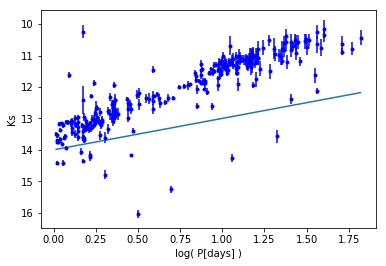

In [64]:
plt.errorbar(log10_period,k_mag,yerr=k_mag_err,fmt='b.')
plt.xlabel('log( P[days] )')
plt.ylabel(r'Ks')
plt.gca().invert_yaxis()

plt.plot(xgrid, model0)

How did it do?  Pick some values of `m0` and `b0` that look good to you.

## Using `astropy.modeling` package to set up a line model

The [astropy.modeling](http://docs.astropy.org/en/stable/modeling/) package contains many analytical functions that are generally useful.  You can find a list of them in [this table](http://docs.astropy.org/en/stable/modeling/#module-astropy.modeling.functional_models)


Let's use one to replace our custom line model function.  We will use the `Linear1D` model object, which we will need to initiate with our favorite $m$ and $b$ values.

In [65]:
linear_model = models.Linear1D(m0, b0)

Now we can evaluate our model by supplying the `linear_model` object with the $x$ values we desire.

Let's plot the linear model with our `xgrid` values, like before.

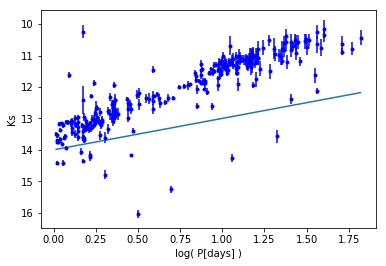

In [66]:
plt.errorbar(log10_period,k_mag,yerr=k_mag_err,fmt='b.')
plt.xlabel('log( P[days] )')
plt.ylabel(r'Ks')
plt.gca().invert_yaxis()

plt.plot(xgrid, linear_model(xgrid))

## Using the `astropy.modeling` to fit the data

Let's plot our data with the error bars this time.

## Setting up your own fitting statistic

## How to generate random data

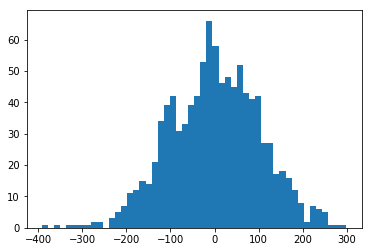

In [11]:
# To begin, we need to define our Guassian parameters (e.g. the mean and standard deviation)
mean  = 0 # This is our mean
sigma = 100 # This is our standard deviation

# To generate our data, we can use the numpy random generator normal distribution function.
# Let's create 1000 points for now. 
gaussian_data = np.random.normal(mean, sigma, 1000)

# bin data and plot a histogram; overplot your guassian fit
# To visualize our data, let's bin it into 50 bins
bins  = 50
_ = plt.hist(gaussian_data, bins)

plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
                np.exp( - (bins - mean)**2 / (2 * sigma**2) ),
          linewidth=2, color='r')
#plt.show()

<Container object of 3 artists>

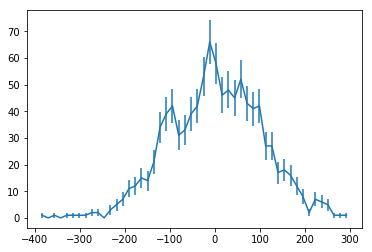

In [12]:
hist_values, bin_edges = np.histogram(gaussian_data, bins)
hist_error = np.sqrt(hist_values)
bin_center = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.errorbar(bin_center, hist_values, yerr=hist_error)

Try playing with the number of data points and see how that changes our error bars. 

# Extra Bonus Objectives

Written by Lia

## How to simulate a stellar spectrum with noise

In this example, we will simulate a black body spectrum with noise.

First, we will load the [black body module](http://docs.astropy.org/en/stable/modeling/#module-astropy.modeling.blackbody) from `Astropy.modeling`

In [13]:
from astropy.modeling.blackbody import blackbody_lambda, blackbody_nu

Now let's set up our model grid for $\lambda$ (the wavelength of the light).  Note that $c = \lambda \nu$, where $\nu$ is the frequency and $c$ is the speed of light.

We will call the variable `wavelength` because `lambda` is a built-in Python construct that we won't be able to use as a variable name.

In [14]:
wmin, wmax = 1000., 10000.  # Angstroms
nbins      = 1000  # Number of bins to use
wavelength = np.linspace(wmin, wmax, nbins) * u.AA  # Angstroms

We'll be using the equation $F_{\lambda} = ???$ with a reasonable temperature for a stellar surface like our sun.

In [15]:
temperature = 6000. * u.K  # Kelvin
intensity_lambda = blackbody_lambda(wavelength, temperature)

Let's see what units were returned by the blackbody function.

In [16]:
print(intensity_lambda.unit)

erg / (Angstrom cm2 s sr)


For a perfectly spherical stellar point source, we multiply the intensity by a factor of $\pi$ (or something) steridians (the sr unit).  

If we want to estimate the number of photon counts in our image, then we also need to multiply the flux by the effective area of our telescope, an exposure time, the energy of the photons as each wavelength, and our bin width.

In [17]:
solid_angle    = np.pi * u.sr
effective_area = 1.e4 * u.cm**2
exposure_time  = 1.0 * 60. * u.s  # 1 minute in units of seconds
photon_energy  = wavelength.to(u.erg, equivalencies=u.spectral())  # See astropy.units tutorial

estimated_counts = intensity_lambda * solid_angle * effective_area * exposure_time / photon_energy

What are the units on estimated_counts?  Why?

Let's get an estimated number of photon counts in each bin

In [18]:
bin_width      = wavelength[1] - wavelength[0]  # Only works if the bins are linearly spaced
counts_per_bin = estimated_counts * bin_width

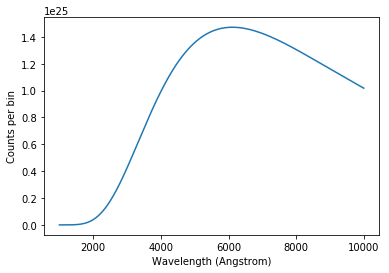

In [19]:
plt.plot(wavelength, counts_per_bin)
plt.xlabel("Wavelength (%s)" % wavelength.unit)
plt.ylabel("Counts per bin")

** Finish this another time **

In [4]:
## Note from Lia -- I just made some random data that goes in a line for now
xmin, xmax, my_m, my_b, ysig = 0, 100., 3.0, 2.0, 50.0
npoints = 100,
aq_x    = np.random.uniform(xmin, xmax, npoints)
aq_y    = np.random.normal(my_m * aq_x + my_b, ysig)
aq_yerr = np.abs(np.random.normal(0.0, ysig/2.0, npoints))  # Use randomly generated error bars for now

Let's make a scatter plot of the data.

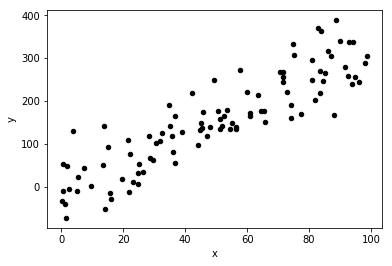

In [5]:
plt.scatter(aq_x, aq_y, s=20, color='k')
plt.xlabel("x")
plt.ylabel("y")